In [91]:
"""
code structure
1. define Class
2. define function load data and return a dataframe of the data
3. generate habitable zone 
4. generate data result visualization 
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy as ap
import astropy.units as apu
from dataclasses import dataclass, field


calculator_list = []
calculate_distance = []

# Use this to load gstar.csv into dataframe:
file_path = r'' # Fill in the required path for where you have gstar.csv dataset saved

df = pd.read_csv(file_path)
print(df.head())

   Unnamed: 0 HIP  Parallax     RA       Dec   Vmag Spectral_Type    Distance
0           2   3      2.81   1.20  385133.4   6.61             G  355.871886
1           5   6     18.80   4.35   35647.4  12.31             G   53.191489
2           6   7     17.74   5.41  200211.8   9.64             G   56.369786
3          19  20     10.76  15.11  233145.4   8.51             G   92.936803
4          22  23     12.21  17.86  131844.0   7.57             G   81.900082


In [107]:
@dataclass
class HabitableZoneCalculator:
    m_v: float  # Apparent magnitude
    d: float  # Distance (parsecs)
    spectral_class: str  # Spectral class of star
    
    """
    stellar_mass: float  # Mass of the star in solar masses
    planet_distance: float  # Distance of the planet in AU
    planet_mass: float  # Mass of the planet in solar masses   
    """

    # Fields with default values or computed during initialization
    BC_dict: dict = field(default_factory=lambda: {'B': -2.0, 'A': -0.3, 'F': -0.15, 'G': -0.4, 'K': -0.8, 'M': -2.0})
    M_bolsun: float = 4.72 
    BC: float = field(init=False)  # Bolometric correction
    M_v: float = field(init=False)  # Absolute magnitude
    luminosity: float = field(init=False) # Solar Luminosity
    inner_edge:float = field(init=False) # AU
    outer_edge:float = field(init=False) # AU

    def __post_init__(self):
        self.M_v = self.calculate_absolute_magnitude()
        self.BC = self.BC_dict.get(self.spectral_class, 0)
        self.luminosity = self.calculate_luminosity()
        self.calculate_habitable_zone()  # Initialize inner_edge and outer_edge

    def calculate_absolute_magnitude(self):
        return self.m_v - 5 * np.log10(self.d / 10)

    def calculate_bolometric_magnitude(self):
        return self.M_v + self.BC

    def calculate_luminosity(self):
        M_bol = self.calculate_bolometric_magnitude()
        L = 10 ** ((M_bol - self.M_bolsun) / -2.5)
        return L if L > 0 and L < 999999 else np.nan

    def calculate_habitable_zone(self):
        _L_star = self.calculate_luminosity()
        self.inner_edge = np.sqrt(_L_star / 1.1)
        self.outer_edge = np.sqrt(_L_star / 0.53)

def calculate_distance(star_entry, calculator_list):
    _star_instance = HabitableZoneCalculator(star_entry['Vmag'], star_entry['Distance'], star_entry['Spectral_Type'])
    calculator_list.append(_star_instance)
    return _star_instance.inner_edge, _star_instance.outer_edge, _star_instance.calculate_luminosity()

calculator_list = []
df[['inner_edge', 'outer_edge', 'luminosity']]=df.apply(lambda x:pd.Series(calculate_distance(x, calculator_list)), axis=1)
Stars = [HabitableZoneCalculator(m_v= _.m_v, d=_.d, spectral_class=_.spectral_class) for _ in calculator_list]

df.dropna(subset=['inner_edge', 'outer_edge','luminosity'], inplace=True)

pd.DataFrame(Stars).query('d < 99999').describe()

,m_v,d,M_bolsun,BC,M_v,luminosity,inner_edge,outer_edge
count,9097.000000,9097.000000,9097.00,9.097000e+03,9097.000000,9097.000000,9097.000000,9097.000000
mean,8.470384,285.846915,4.72,-4.000000e-01,2.677047,350.150908,6.322117,9.107956
std,1.495823,876.101971,0.00,5.551420e-17,2.744323,6143.541141,16.684737,24.036862
min,0.400000,1.821460,4.72,-4.000000e-01,-8.535150,0.000244,0.014906,0.021475
25%,7.680000,75.131480,4.72,-4.000000e-01,0.954376,2.908122,1.625960,2.342440
50%,8.370000,143.472023,4.72,-4.000000e-01,2.426420,11.951769,3.296247,4.748738
75%,9.290000,263.852243,4.72,-4.000000e-01,3.960968,46.371353,6.492748,9.353776
max,12.880000,33333.333333,4.72,-4.000000e-01,14.149651,289774.384030,513.255549,739.421477


Text(0.5, 1.0, 'HZ vs. Luminosity')

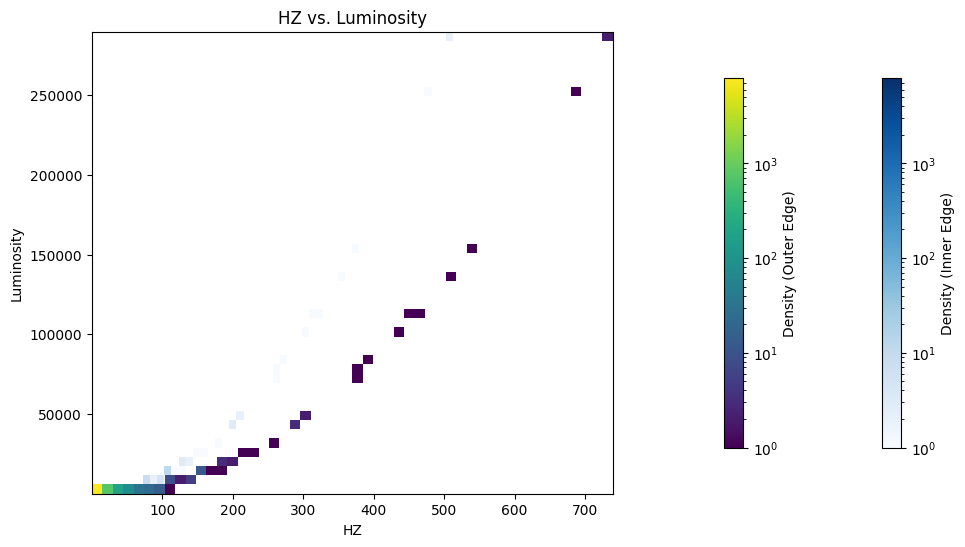

In [109]:
plt.figure(figsize=(12, 6))
h1 = plt.hist2d(df['inner_edge'], df['luminosity'], bins=(50,50), norm='log', cmap='magma', label='Inner Edge')
h2 = plt.hist2d(df['outer_edge'], df['luminosity'], bins=(50,50), norm='log', cmap='cividis', label='Outer Edge')
plt.colorbar(h1[3], label='Density (Inner Edge)', shrink=0.8)
plt.colorbar(h2[3], label='Density (Outer Edge)', shrink=0.8, pad=0.15)
# plt.xlim(b1, b2)
# plt.ylim(b1, b2)
plt.xlabel('HZ')
plt.ylabel('Luminosity')
plt.title('HZ vs. Luminosity')